In [6]:
import os
import sys
import copy
import time
import pickle
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
from random import randint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

In [37]:
# self-defined modules

import importlib
from client_update import *
from server_update import *
from models import *
from utlis import *

In [36]:
# Note: please re-import above class after reloading this block to avoid possible errors!!!!!

importlib.reload(sys.modules['client_update'])
importlib.reload(sys.modules['server_update'])
importlib.reload(sys.modules['models'])

<module 'models' from '/home/ec2-user/SageMaker/src/models.py'>

In [10]:
sys.version

'3.6.13 | packaged by conda-forge | (default, Feb 19 2021, 05:36:01) \n[GCC 9.3.0]'

In [31]:
os.path.abspath('FL_main')

'/home/ec2-user/SageMaker/src/FL_main'

## Load datasets

In [14]:
mimic_train_x = np.load(r"/home/ec2-user/SageMaker/save/mimic_train_x.npy")
mimic_train_y = np.load(r"/home/ec2-user/SageMaker/save/mimic_train_y.npy")
mimic_val_x = np.load(r"/home/ec2-user/SageMaker/save/mimic_val_x.npy")
mimic_val_y = np.load(r"/home/ec2-user/SageMaker/save/mimic_val_y.npy")

mimic_train_set = CombineDataset(mimic_train_x, mimic_train_y)
mimic_val_set = CombineDataset(mimic_val_x, mimic_val_y)
print(len(mimic_train_set),len(mimic_val_set))

3172 1136


## Centralized learning

In the centralized setting, all of the training set is in one place, so I set client number = 1.

In [18]:
# one client
centralized_client_dict = iid_partition(mimic_train_set, 1)

In [19]:
print('dataset size:', len(centralized_client_dict[0]))

dataset size: 3172


In [25]:
print('the number of clients:', len(centralized_client_dict))

the number of clients: 1


### Set parameters

In [22]:
config = {
    'mimic': {
        'train_set': mimic_train_set, 
        'val_set': mimic_val_set, 
        'learning_rate': 0.001, 
        'batch_size': 124,
        'epochs': 10}, 
    'guch': {
        'train_set': 'guch_train_set', 
        'val_set': 'guch_val_set', 
        'learning_rate': 0.01, 
        'batch_size': 124,
        'epochs': 10}
}

entity = ['mimic','guch'] # the entity who join in federated learning
rounds = 50 # number of training rounds
M = len(centralized_client_dict) # number of entities    
num_classes = 3
classes = [0, 1, 2]

input_size =  13 #  the number of features
hidden_size = 40
num_layers = 2
dropout = 0.2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

if torch.cuda.is_available():
    lstm.cuda()

### Model training

Round: 1... 	Average Loss: 0.773
Round: 2... 	Average Loss: 0.647
Round: 3... 	Average Loss: 0.619
Round: 4... 	Average Loss: 0.605
Round: 5... 	Average Loss: 0.594
Round: 6... 	Average Loss: 0.591
Round: 7... 	Average Loss: 0.588
Round: 8... 	Average Loss: 0.588
Round: 9... 	Average Loss: 0.588
Round: 10... 	Average Loss: 0.587
Round: 11... 	Average Loss: 0.588
Round: 12... 	Average Loss: 0.588
Round: 13... 	Average Loss: 0.587
Round: 14... 	Average Loss: 0.587
Round: 15... 	Average Loss: 0.586
Round: 16... 	Average Loss: 0.587
Round: 17... 	Average Loss: 0.587
Round: 18... 	Average Loss: 0.586
Round: 19... 	Average Loss: 0.586
Round: 20... 	Average Loss: 0.586
Round: 21... 	Average Loss: 0.587
Round: 22... 	Average Loss: 0.585
Round: 23... 	Average Loss: 0.585
Round: 24... 	Average Loss: 0.585
Round: 25... 	Average Loss: 0.585
Round: 26... 	Average Loss: 0.585
Round: 27... 	Average Loss: 0.585
Round: 28... 	Average Loss: 0.585
Round: 29... 	Average Loss: 0.585
Round: 30... 	Average L

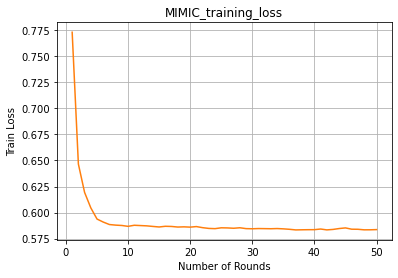

In [23]:
mimic_lstm_training = global_update(lstm, rounds, M, 'mimic', centralized_client_dict, config,  "MIMIC_training_loss", "orange")

### Model testing

In [26]:
criterion = nn.CrossEntropyLoss()
pred = testing(mimic_lstm_training, 'mimic', config, criterion, num_classes, classes)

Test Loss: 0.587766

Test Accuracy of     0: 100% (307/307)
Test Accuracy of     1: 98% (698/711)
Test Accuracy of     2: 76% (90/118)

Final Test  Accuracy: 96.391 (1095.0/1136.0)


### Evaluation

In [27]:
def transfer_labels(labels):
    var = []
    for i in range(0, labels.shape[0]):
        var.append(labels[i][47][0])
    return var

In [28]:
def transfer_predictions(array):
    '''
    transfer to a list 
    '''
    var = []
    for j in range(0,len(array)):
        var = var + array[j].tolist() # notice the order!
    one_size_array = np.reshape(var,-1)
    return one_size_array.tolist()

In [29]:
y_test = transfer_labels(mimic_val_y)

In [30]:
predictions = transfer_predictions(pred)

In [31]:
cm = confusion_matrix(y_test, predictions)
normed_cm = (cm.T / cm.astype(np.float).sum(axis=1)).T
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

In [32]:
print('recall:', recall)
print('precision', precision)

recall: [1.         0.98171589 0.76271186]
precision [0.99675325 0.96275862 0.87378641]


Text(0.5, 1.0, 'Confusion Matrix')

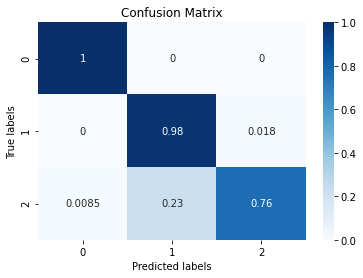

In [33]:
import seaborn as sns
ax= plt.subplot()
sns.heatmap(normed_cm, annot=True, cmap='Blues', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
#ax.xaxis.set_ticklabels(['business', 'health']); ax.yaxis.set_ticklabels(['health', 'business']);

In [34]:
torch.save(mimic_lstm_training.state_dict(), r'/home/ec2-user/SageMaker/save/lstm_mimic_model_centralized_training')

## Federated learning with the iid distribution

Data in each client follow iid distribution. Here, the number of clients is set to be 5.



In [39]:
iid_client_dict = iid_partition(mimic_train_set, 5)

In [40]:
M = len(iid_client_dict) # number of entities    

[0.910711825758877, 0.890505133724363, 0.899142116383423, 0.8761878965592912, 0.895178726926587]
Round: 1... 	Average Loss: 0.894
[0.7725624978730355, 0.7403453656363563, 0.7493656007085313, 0.7064624959362041, 0.7442440111554383]
Round: 2... 	Average Loss: 0.743
[0.7544460709538745, 0.7220137473912644, 0.7344663705359499, 0.6947028766671189, 0.7259968305611836]
Round: 3... 	Average Loss: 0.726
[0.7341009587331524, 0.6884901974855538, 0.6991821729046315, 0.6730006077500171, 0.6909292509315141]
Round: 4... 	Average Loss: 0.697
[0.7163570860394921, 0.6543659610703163, 0.6850415409739462, 0.6512452430153495, 0.66840462530449]
Round: 5... 	Average Loss: 0.675
[0.6952799746290743, 0.6448726158224822, 0.6652077128458475, 0.655624853511714, 0.6597806079718592]
Round: 6... 	Average Loss: 0.664
[0.717818923741109, 0.6398168825388706, 0.6519156053239239, 0.633870714827667, 0.6513189951516101]
Round: 7... 	Average Loss: 0.659
[0.6953998255804886, 0.6324576192473763, 0.6496897787513792, 0.63137054

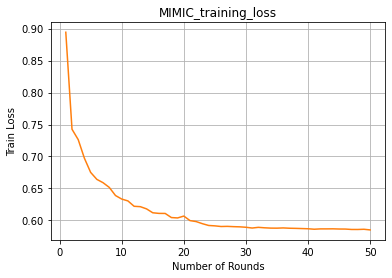

In [42]:
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

mimic_lstm_training = global_update(lstm, rounds, M, 'mimic', iid_client_dict, config,  "MIMIC_training_loss", "orange")

In [43]:
criterion = nn.CrossEntropyLoss()
pred = testing(mimic_lstm_training, 'mimic', config, criterion, num_classes, classes)

Test Loss: 0.585003

Test Accuracy of     0: 100% (307/307)
Test Accuracy of     1: 98% (699/711)
Test Accuracy of     2: 77% (92/118)

Final Test  Accuracy: 96.655 (1098.0/1136.0)


In [44]:
y_test = transfer_labels(mimic_val_y)

In [45]:
predictions = transfer_predictions(pred)

In [46]:
cm = confusion_matrix(y_test, predictions)
normed_cm = (cm.T / cm.astype(np.float).sum(axis=1)).T
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

In [47]:
print('recall:', recall)
print('precision', precision)

recall: [1.         0.98312236 0.77966102]
precision [1.         0.96413793 0.88461538]


Text(0.5, 1.0, 'Confusion Matrix')

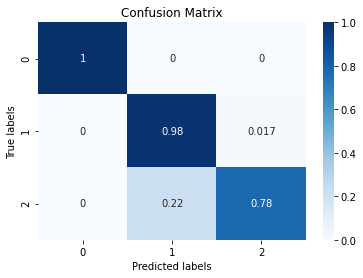

In [48]:
import seaborn as sns
ax= plt.subplot()
sns.heatmap(normed_cm, annot=True, cmap='Blues', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
#ax.xaxis.set_ticklabels(['business', 'health']); ax.yaxis.set_ticklabels(['health', 'business']);

In [49]:
torch.save(mimic_lstm_training.state_dict(), r'/home/ec2-user/SageMaker/save/lstm_mimic_model_iid_training')

## Federated learning with the Non iid distribution

Data in each client follow non-iid distribution. This is more practical situtaiton in the real life. Here, the number of clients is set to be 5.

https://xzhu0027.gitbook.io/blog/ml-system/sys-ml-index/learning-from-non-iid-data

In [50]:
y_label = transfer_labels(mimic_train_set.y)

In [51]:
non_iid_client_dict = non_iid_partition(mimic_train_set, y_label, 5, 100, 30, 5)

In [52]:
M = len(non_iid_client_dict) # number of entities    

[1.049997786362966, 1.064613365252813, 1.049385752995809, 1.0615125172932944, 1.0424571584860485]
Round: 1... 	Average Loss: 1.054
[0.8351494747002921, 0.9125046166578927, 0.8939109811782838, 0.8417975937525431, 0.9195646843115488]
Round: 2... 	Average Loss: 0.881
[0.6348214667638143, 0.7873761779467265, 0.7895078076521556, 0.6294750398794811, 0.8735403824647268]
Round: 3... 	Average Loss: 0.743
[0.5911797765890757, 0.7598629217942556, 0.770517986059189, 0.579303194443385, 0.8885389783382415]
Round: 4... 	Average Loss: 0.718
[0.5754150351683298, 0.7486206185022989, 0.7586265012423199, 0.5673852690855662, 0.8940418407917023]
Round: 5... 	Average Loss: 0.709
[0.5703009052276612, 0.7402369981606802, 0.7467627934614817, 0.5631384208202361, 0.869662907997767]
Round: 6... 	Average Loss: 0.698
[0.5682301537990571, 0.7329235650698344, 0.7384475281238556, 0.561449546178182, 0.8551012059847516]
Round: 7... 	Average Loss: 0.691
[0.5674693190256754, 0.729194187561671, 0.7291948467890421, 0.5567828

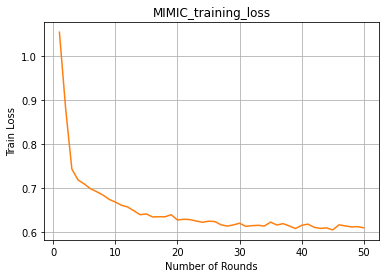

In [53]:
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

mimic_lstm_training = global_update(lstm, rounds, M, 'mimic', non_iid_client_dict, config,  "MIMIC_training_loss", "orange")

In [54]:
criterion = nn.CrossEntropyLoss()
pred = testing(mimic_lstm_training, 'mimic', config, criterion, num_classes, classes)

Test Loss: 0.641277

Test Accuracy of     0: 100% (307/307)
Test Accuracy of     1: 94% (674/711)
Test Accuracy of     2: 45% (54/118)

Final Test  Accuracy: 91.109 (1035.0/1136.0)


In [55]:
y_test = transfer_labels(mimic_val_y)

In [56]:
predictions = transfer_predictions(pred)

In [57]:
cm = confusion_matrix(y_test, predictions)
normed_cm = (cm.T / cm.astype(np.float).sum(axis=1)).T
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

In [58]:
print('recall:', recall)
print('precision', precision)

recall: [1.         0.94796062 0.45762712]
precision [0.99675325 0.91451832 0.59340659]


Text(0.5, 1.0, 'Confusion Matrix')

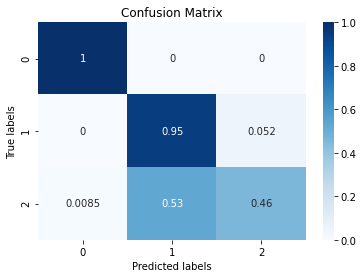

In [59]:
import seaborn as sns
ax= plt.subplot()
sns.heatmap(normed_cm, annot=True, cmap='Blues', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
#ax.xaxis.set_ticklabels(['business', 'health']); ax.yaxis.set_ticklabels(['health', 'business']);

In [60]:
torch.save(mimic_lstm_training.state_dict(), r'/home/ec2-user/SageMaker/save/lstm_mimic_model_noniid_training')

The result of 100 rounds training.
---

[1.0754880612691244, 1.0515573042233783, 1.0708331971963247, 1.0709035144646963, 1.0561579184532164]
Round: 1... 	Average Loss: 1.065
[0.8468877081076304, 0.8954417556921641, 0.9173249348799388, 0.8345431981881459, 0.9449336638450623]
Round: 2... 	Average Loss: 0.888
[0.630124368349711, 0.7716965305805206, 0.7987769140402475, 0.6158329135576883, 0.890355711142222]
Round: 3... 	Average Loss: 0.741
[0.5855474030971528, 0.7545190877119701, 0.774208825747172, 0.5771353100935618, 0.8931929959456125]
Round: 4... 	Average Loss: 0.717
[0.575645537217458, 0.743565540154775, 0.75913809744517, 0.5665289402008057, 0.8869545345306398]
Round: 5... 	Average Loss: 0.706
[0.5706844225724538, 0.7390681695143382, 0.7467047371069591, 0.563538026491801, 0.8672492246627808]
Round: 6... 	Average Loss: 0.697
[0.5682624662717183, 0.7292592918078105, 0.7352390775680543, 0.560839464823405, 0.8577554260094962]
Round: 7... 	Average Loss: 0.69
[0.5674430094559987, 0.719734347184499, 0.7293674279848734, 0.5563364494

[0.5514452848434448, 0.6018374470074971, 0.6125512498219808, 0.5514450217088065, 0.6407936813036601]
Round: 63... 	Average Loss: 0.592
[0.5514451056321462, 0.5989164988199869, 0.615700470050176, 0.551485944112142, 0.6307962175210317]
Round: 64... 	Average Loss: 0.59
[0.5514450898965201, 0.6014300243854522, 0.5952450985908507, 0.551447293361028, 0.6336453864574432]
Round: 65... 	Average Loss: 0.587
[0.5514452589352927, 0.6028818736076353, 0.5918187824885052, 0.5514451064268749, 0.6415926965077717]
Round: 66... 	Average Loss: 0.588
[0.551445260445277, 0.6009311504364014, 0.5923495552539826, 0.5514463863372803, 0.6379753470420837]
Round: 67... 	Average Loss: 0.587
[0.5514453234672547, 0.5984995161692301, 0.6020855856736501, 0.5525920766194662, 0.6273722118536631]
Round: 68... 	Average Loss: 0.586
[0.5514462895393372, 0.6057986561457317, 0.607301565806071, 0.5527324063777923, 0.6232193063894906]
Round: 69... 	Average Loss: 0.588
[0.5514451340039572, 0.6013524234294891, 0.5910236190160114, 

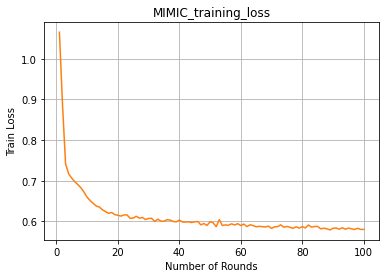

In [61]:
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
rounds = 100 # number of training rounds

mimic_lstm_training = global_update(lstm, rounds, M, 'mimic', non_iid_client_dict, config,  "MIMIC_training_loss", "orange")

In [62]:
criterion = nn.CrossEntropyLoss()
pred = testing(mimic_lstm_training, 'mimic', config, criterion, num_classes, classes)

Test Loss: 0.629984

Test Accuracy of     0: 100% (307/307)
Test Accuracy of     1: 96% (685/711)
Test Accuracy of     2: 46% (55/118)

Final Test  Accuracy: 92.165 (1047.0/1136.0)


In [63]:
y_test = transfer_labels(mimic_val_y)
predictions = transfer_predictions(pred)

cm = confusion_matrix(y_test, predictions)
normed_cm = (cm.T / cm.astype(np.float).sum(axis=1)).T
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

In [64]:
print('recall:', recall)
print('precision', precision)

recall: [1.         0.96343179 0.46610169]
precision [0.99675325 0.91700134 0.67901235]


Text(0.5, 1.0, 'Confusion Matrix')

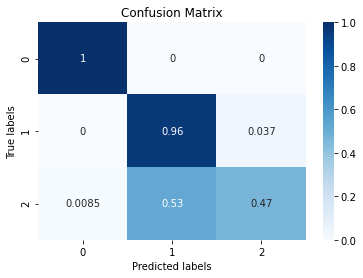

In [65]:
import seaborn as sns
ax= plt.subplot()
sns.heatmap(normed_cm, annot=True, cmap='Blues', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
#ax.xaxis.set_ticklabels(['business', 'health']); ax.yaxis.set_ticklabels(['health', 'business']);